In [1]:
%matplotlib inline
import pylab as plt
import pandas

# Generate initial data

In [2]:
import numpy as np

N = 5000

Train = pandas.read_csv("./train.csv")
Test = pandas.read_csv("./test.csv")

print(Test.head())
Col = list(Train.columns.values)
Col.remove("Unnamed: 0")
Col.remove("TARGET")

   Unnamed: 0  AVG_anticipation_when_early_f  \
0           0                      -0.440374   
1           1                      -0.422862   
2           2                      -0.439164   
3           3                      -0.440374   
4           4                      -0.439138   

   AVG_delay_over_remaining_days_distinct_f  \
0                                  0.548367   
1                                 -0.281821   
2                                 -0.098044   
3                                  0.143614   
4                                  0.539484   

   AVG_delay_over_remaining_days_distinct_last10_f  \
0                                         0.390253   
1                                        -0.236425   
2                                        -0.145258   
3                                         0.094592   
4                                         0.064250   

   AVG_delay_over_remaining_days_distinct_last3_f  \
0                                        0.406523 

In [7]:
#tokeep.pop(0)
#print (tokeep)
tokeep = [7, 11, 12, 13, 16, 20, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

In [8]:
N = len(Train["TARGET"])
X_train = np.array([np.ones(N)] + [Train[icol] for icol in Col]).T[::,tokeep]
print(X_train.shape)
y_train = Train["TARGET"]
N = len(Test["TARGET"])
X_test = np.array([np.ones(N)] + [Test[icol] for icol in Col]).T[::,tokeep]
print( X_test.shape)
y_test = Test["TARGET"]

print(np.sum(np.isnan(X_train)))
print( X_train.mean(axis=0))
#print(Col)

(263404, 22)
(65852, 22)
0
[  7.53692580e-17  -2.92615614e-17  -3.77048606e-17  -5.55153661e-17
  -4.57232972e-18   4.99044837e-19  -4.25671758e-17  -1.85590728e-17
  -4.66822725e-16   8.92480995e-17  -2.43048323e-17   8.63212690e-19
   3.37192457e-18  -8.74812111e-17   6.71687375e-18  -1.90850931e-17
  -4.69102146e-17   1.15050066e-17   2.90635620e-15  -1.24909574e-15
   4.92300987e-19   2.23167456e-16]


In [ ]:
print(X_test[1].shape)

## Create the model

In [9]:
import pymc3
from pymc3 import Bernoulli,Cauchy,Model
import theano.tensor as T
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    beta = Cauchy('beta', alpha=0, beta=5, shape=X_train.shape[1])
    
    x = T.dot(X_train,beta)
    x = x + 0.5
    # I couldn't implement gaussian cdf
    # But this function is close to the cdf (Cf nlast cell)
    c_normal = 1./(1+T.exp(-1.75*x))

    # Likelihood (sampling distribution) of observations
    Y_obs = Bernoulli('Y_obs', p=c_normal, observed=y_train)

# Estimate the maximum a posteriori

In [10]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)

print("Estimate",map_estimate)
#print("Groud truth",betas_v)

Estimate {'beta': array([ -3.64750722e-02,  -1.34288546e-01,   1.09841615e-01,
        -3.42964691e-02,   1.52990294e-01,  -5.89281028e-02,
        -8.53250827e-02,   1.48648365e-01,  -2.63072164e-02,
        -6.67125599e-02,  -1.69414309e-01,  -8.67936180e-02,
        -8.35523969e-02,   4.54702194e-02,  -1.07842810e-02,
        -1.21429224e-02,  -6.96908448e-02,   3.31393449e-01,
         1.56895523e-02,  -1.02948345e-02,   1.64774308e-04,
         4.47505690e-02])}


In [11]:
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(100,start=start)

100%|██████████| 100/100 [06:35<00:00,  4.22s/it]


In [ ]:
import pickle
np.savetxt("trace_30.pick",trace["beta"].mean(axis=0))
#with open("trace_30.pick","w") as f:
#    pickle.dump(trace["beta"].mean(axis=0),f)

In [12]:
print(trace["beta"].mean(axis=0))

[ -3.67397487e-02  -1.34698143e-01   2.99184832e-02  -3.42938831e-02
   1.53325394e-01  -5.92893329e-02  -8.51906207e-02   1.48765086e-01
  -2.64556581e-02  -6.64453892e-02  -1.69224398e-01  -8.71304321e-02
  -8.28503256e-02   4.53429139e-02  -1.08502880e-02  -1.23120040e-02
  -6.93604922e-02   2.51366482e-01   1.59386264e-02  -1.04691930e-02
  -2.88680995e-05   4.48785343e-02]


(263404,)
[[ 0.10451626  0.05084205]
 [ 0.39212009  0.4525216 ]]
[[ 0.10487153  0.05229909]
 [ 0.39285063  0.44997874]]


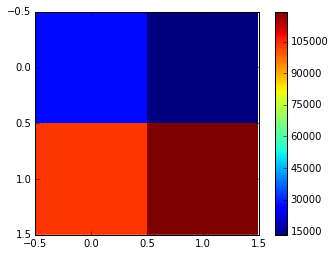

In [13]:
from sklearn.metrics import confusion_matrix
def P(X,beta):
    x = np.dot(X,beta)
    return 1./(1+np.exp(-1.75*x))
betas = trace["beta"].mean(axis=0)
betas[0] = .5
res = P(X_train,betas) > 0.5
print(res.shape)
cf = confusion_matrix(y_train,res)
plt.imshow(cf,interpolation="None")
plt.colorbar()
print(cf / len(y_train))

print(confusion_matrix(y_test, P(X_test,betas) > 0.5)/len(y_test))

## Show the trace and the distribution of the samples

In [15]:
from pymc3 import traceplot,summary


In [ ]:
tokeep = [i + 30 for i,v in enumerate(trace["beta"].mean(axis=0)) if v >0.05 or v < -0.05]
loaded_trace = np.loadtxt("./trace_30.pick")
print(loaded_trace)
tokeep = [i  for i,v in enumerate(loaded_trace) if v >0.05 or v < -0.05] + tokeep
print(tokeep)


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.037           0.004            0.000            [-0.045, -0.029]
  -0.135           0.003            0.000            [-0.142, -0.130]
  0.030            0.109            0.011            [-0.156, 0.161]
  -0.034           0.002            0.000            [-0.038, -0.031]
  0.153            0.006            0.001            [0.143, 0.164]
  -0.059           0.006            0.001            [-0.070, -0.048]
  -0.085           0.003            0.000            [-0.090, -0.079]
  0.149            0.005            0.000            [0.139, 0.156]
  -0.026           0.003            0.000            [-0.033, -0.022]
  -0.066           0.004            0.000            [-0.073, -0.059]
  -0.169           0.005            0.000            [-0.178, -0.159]
  -0.087           0.007            0.001            [-0.104, -0.077]
  -0.083      

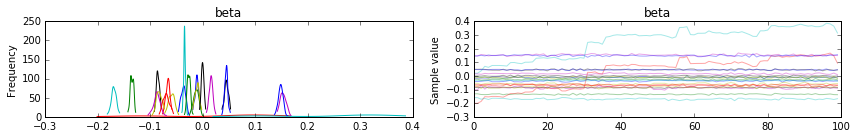

In [17]:
#print("Groud truth",betas_v)
traceplot(trace);
summary(trace)

## Comparison cdf vs sigmoid

In [ ]:
x = np.arange(-10,10,0.01)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
plt.title("Comparison")
plt.plot(x,norm.cdf(x),label="cdf")
plt.plot(x,1/(1+np.exp(-1.75*x)),label="sigmoid")
plt.legend(loc="best")
ax = f.add_subplot(122)
plt.title("Difference")
plt.plot(x,norm.cdf(x)-1/(1+np.exp(-1.75*x)),label="difference")
plt.legend()
